# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we explore some of the textual features of those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import sqlite3
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
import regex as re
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, \
 compile_infix_regex, compile_suffix_regex
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "C:/Users/fkrasovsky/OneDrive - Allvue Systems/Documents/usd/msads-509/Module-1-Scraping-APIs-and Research Questions"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [4]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    
    num_tokens = len(tokens)
    
    #Coercion to the set type gives us unique tokens.
    num_unique_tokens = len(set(tokens))
    
    #there are many ways to calculate diversity, we can use TTR - which is the ratio of unique types to total tokens,
    # or the type-token-ratio, which is calculated from dividing the unique tokens by the total number of tokens.
    lexical_diversity = (num_unique_tokens / num_tokens)
    
    #this can be done by getting the length of each token passed to our function.
    num_characters = sum([len(t) for t in text])
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        # we can accomplish this by creating a dataframe and turning it into a series.
        n = pd.DataFrame(tokens,columns=['token'])\
            .value_counts()\
            .sort_values(ascending=False)
        print('Five most common tokens:')
        print(n.head(5))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [5]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)

There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.
Five most common tokens:
token  
text       3
example    2
here       2
in         1
is         1
dtype: int64


**Q: Why is it beneficial to use assertion statements in your code?**

A: Assertion statements allow us to create a sanity check to ensure the logic we've embedded into our code is correct in an easy, scalable way.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




**Developer's Note: Many of the text files for smash mouth were parsed incorrectly, with the carriage return missing between the first word and last word of two lines, leaving us with frankenwords such as itDescribe, ballAnd, and more. we will write a regex function that separate the two words.**

In [6]:
def deFrankenSteinify(word):
    
    reg_str = '\B[A-Z]{1}.*'
    franken_search = re.search(reg_str,word)
    
    if (franken_search is None or len(franken_search[0])==len(word)):
        return [word]
    else:
        second_word = franken_search[0]
        #get the index of the start of the match of the second word and get everything 
        #up until that point
        first_word  = word[:franken_search.span()[0]]
        return [first_word,second_word]

In [7]:
#iterate over our string, temporarily tokenize it, and create a new string where each word is no longer a frankenword.
def deFrankenSteinifyText(text):
    tokens = text.split()
    out = []
    for token in tokens:
        this_token_list = deFrankenSteinify(token)
        out = out + this_token_list
    return ' '.join(out)

In [8]:
deFrankenSteinifyText('Somebody once told me theWorld was gonna roll me')

'Somebody once told me the World was gonna roll me'

#### **Lyrics Data Ingestion**

In [170]:
# Read in the lyrics data

# point at the folder containing lyrics for all our artists
lyrics_path = data_location+'/'+lyrics_folder
artists = os.listdir(lyrics_path)

#iterate over both artists, get a list of all the text files containing their songs, read them into separate dataframes.
#we can create dynamic variable names for the dfs using the globals function.

song_artist = []
song_names = []
song_lyrics = []

for artist in artists:
    
    artist_path = lyrics_path + artist
    songs = os.listdir(artist_path)

    # get each song for our artist, read it in as a string, and append it to a list.
    for song in songs:
        song_path = artist_path + '/' + song
        
        with open(song_path) as f:
            lines = f.readlines()

        # we also need a meaningful way to extract the song name. the rule for 
        # this dataset is that the title is separated by at least one carriage return,
        # and we also know that it's always on the first line.
        
        this_song = lines[0]
        this_lyrics = ' '.join(lines[1:])
        
        song_artist.append(artist)
        song_names.append(this_song)
        song_lyrics.append(this_lyrics)

d = {
        'artist':song_artist,
        'song_name': song_names,
        'text': song_lyrics
    }

#turn into a datafreame and do a sanity check
df = pd.DataFrame(d)
df.head()

,artist,song_name,text
0,smash mouth,105\n,\n \n \n \n Why the hell are we waitin' in lin...
1,smash mouth,2000 Miles\n,\n \n \n \n He's gone 2000 miles\n It's very f...
2,smash mouth,All Star\n,\n \n \n \n Somebody once told me the world is...
3,smash mouth,Always Gets Her Way\n,\n \n \n \n I know she likes her magazines\n \...
4,smash mouth,Beautiful Bomb\n,\n \n \n \n Your asteroids bounce off her like...


#### **Twitter Data Ingestion**

In [193]:
#read in the twitter data
twitter_path = data_location+'/'+twitter_folder
descriptions = []

for file in os.listdir(twitter_path):
    if (file.split('.')[1]=='tsv'):
        
        artist_name = file.split('_')[0]
        follower_data = pd.read_csv(twitter_path+'/'+file,sep='\t')
        follower_data['artist'] = artist_name
        follower_desc = follower_data[['description','artist']]
        descriptions.append(follower_desc)
        
twitter_df = pd.DataFrame(descriptions[0].append(descriptions[1], 
                  ignore_index = True),columns=['description','artist'])
twitter_df = twitter_df.rename(columns={"description": "text"})
twitter_df.head()

,text,artist
0,I'm whatever SHHS'21 Not on Twitter much..,smashmouth
1,NaN,smashmouth
2,17 | i game occasionally | matching with @batb...,smashmouth
3,22 He/Him Spotted Hyena British Autistic I lik...,smashmouth
4,26 • Guy who games • BotW glitch enthusiast • ...,smashmouth


## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [40]:
punctuation = set(punctuation) # speeds up comparison

In [41]:
def unpunctify(text):
    out=text
    for e in punctuation:
        regstr = f'[\{e}]'
        out = re.sub(regstr,'',out)
    return out

We can also create a function that tells us how impure our corpus is for an initial inspection.

In [42]:
import re
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

#create a function that keeps track of how impure our datasets are to see how much cleaning is needed and 
#if our cleaning had any meaningful effect.

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

Finally, we want a function that both tokenizes and removes stop words from the corpus as well as lemmatizes it.
**The problem with using punctuated stop words for removal is that by the time we get to stop word removal, our corpus will have been tokenized and stripped of punctuation. as a result, we need to add the ``sw`` list to our nlp object without any punctuation.**

In [194]:
nlp = spacy.load('en_core_web_sm')
nlp.tokenizer = Tokenizer(nlp.vocab, token_match=re.compile(r'\S+').match)
for i in sw:
    unpunctsw = re.sub('[^a-zA-Z]','',i)
    #print(i,unpunctsw)
    nlp.vocab[unpunctsw].is_stop = True
    nlp.vocab[i].is_stop = True

In [195]:
def remove_stop_words(text):
    doc = nlp(text)
    return [t.text.strip()
            for t in doc 
            if (not t.is_stop) 
            and (not t.is_punct)
            and (not t.is_space) 
            #and t.pos_ in ['NOUN', 'PROPN','VERB']
           ]

### Cleaning Twitter Data

In [196]:
#  make sure everything has been cast to string.
twitter_df['text'] = twitter_df['text'].map(str)
#  calculate the impurity of our text
twitter_df['impurity'] = twitter_df['text'].apply(impurity,min_len=10)
# get the top 5 records
twitter_df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head()

,text,impurity
69723,{♉} {17} {pansexual} {🎨} {she/they},0.285714
74582,[̲̅a̲̅] [̲̅r̲̅] [̲̅t̲̅] [̲̅i̲̅] [̲̅s̲̅] [̲̅t̲̅],0.255319
116601,"&:&,$7/&.'dhuiskxn$&3&n",0.217391
103596,치치🍒 #리사 #로제 #제니 #지수,0.210526
3214,¥¥{§÷÷{¶¶{÷) #=/2486DEG]¥D#=+%54¶¦|÷]¿]¥©}÷,0.209302


Initial observation suggests that twitter data is incredibly messy in edge cases. We begin by removing punctuation characters, splitting on whitespace, folding to lowercase, and removing stopwords.

In [197]:
# 1. remove punctuation
twitter_df['clean_text'] = twitter_df['text'].map(unpunctify)

# 2. make lowercase
twitter_df['clean_text'] = twitter_df['clean_text'].map(str.lower)

In [198]:
# 3. remove stop words and split on whitespace by modifying the spacey NLP object. we can also filter out spaces.
# THIS FUNCTION ALSO TOKENIZES AND LEMMATIZES.
twitter_df['tokens'] = twitter_df['clean_text'].apply(remove_stop_words)
twitter_df.head()

,text,artist,impurity,clean_text,tokens
0,I'm whatever SHHS'21 Not on Twitter much..,smashmouth,0.000000,im whatever shhs21 not on twitter much,"[im, shhs21, twitter]"
1,nan,smashmouth,0.000000,nan,[nan]
2,17 | i game occasionally | matching with @batb...,smashmouth,0.000000,17 i game occasionally matching with batben55,"[17, game, occasionally, matching, batben55]"
3,22 He/Him Spotted Hyena British Autistic I lik...,smashmouth,0.013158,22 hehim spotted hyena british autistic i like...,"[22, hehim, spotted, hyena, british, autistic,..."
4,26 • Guy who games • BotW glitch enthusiast • ...,smashmouth,0.025974,26 • guy who games • botw glitch enthusiast • ...,"[26, guy, games, botw, glitch, enthusiast, ban..."


**To see if our efforts worked, let's examine the text one more time for impurity.**

In [201]:
twitter_df['impurity'] = twitter_df['clean_text'].apply(impurity,min_len=10)
# get the top 5 records
twitter_df[['clean_text', 'impurity']].sort_values(by='impurity', ascending=False).head()

,clean_text,impurity
0,im whatever shhs21 not on twitter much,0.0
79834,nan,0.0
79846,me is here,0.0
79845,sheher,0.0
79844,quackity acepto sobornos,0.0


In [204]:
twitter_df = twitter_df.rename(columns={"clean_text": "text", "text": "raw_text"})
twitter_df = twitter_df.drop(columns=['impurity'])
twitter_df.head()

,raw_text,artist,text,tokens
0,I'm whatever SHHS'21 Not on Twitter much..,smashmouth,im whatever shhs21 not on twitter much,"[im, shhs21, twitter]"
1,nan,smashmouth,nan,[nan]
2,17 | i game occasionally | matching with @batb...,smashmouth,17 i game occasionally matching with batben55,"[17, game, occasionally, matching, batben55]"
3,22 He/Him Spotted Hyena British Autistic I lik...,smashmouth,22 hehim spotted hyena british autistic i like...,"[22, hehim, spotted, hyena, british, autistic,..."
4,26 • Guy who games • BotW glitch enthusiast • ...,smashmouth,26 • guy who games • botw glitch enthusiast • ...,"[26, guy, games, botw, glitch, enthusiast, ban..."


### Cleaning Lyrics Data

**Developer's Note: The unique circumstances of our lyrics data require us to un-frankenstein lines that were mashed together by running the corpus through one additional element in the pipeline, the frankensteinify function we made earlier, after we tokenize words.**

In [171]:
# create your clean lyrics data here

#  make sure everything has been cast to string.
df['text'] = df['text'].map(str)

# calculate the impurity of our text
df['impurity'] = df['text'].apply(impurity,min_len=10)
# get the first 5 more impure lyrics
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head()

,text,impurity
92,\n \n \n [orig. performed by WAR]\n \n \n Why ...,0.013917
9,\n \n \n \n You must admit that\n You look lik...,0.009891
56,\n \n \n \n Paintings of dogs playing pool\n \...,0.008639
68,\n \n \n [Verse:]\n I canÃ¢Â€Â™t help look in ...,0.007801
29,\n \n \n \n Today's escape will consist of a m...,0.007788


we're not particularly worried about impurity in this case - our worst candidate is less than 1.5% impure.

In [172]:
# 1. remove punctuation
df['text'] = df['text'].map(unpunctify)
# 1b. remove newlines
df['text'] = df['text'].apply(lambda x: x.replace("\n", ""))
# 2. unfrankensteinify!
df['text'] = df['text'].map(deFrankenSteinifyText)
# 3. lowercase
df['text'] = df['text'].apply(lambda x: x.lower())
# 4. tokenize and get rid of stop words and lemmatize
df['tokens'] = df['text'].apply(remove_stop_words)
# 5. morbid curiosity
df['num_tokens'] = df['tokens'].apply(len)

In [173]:
df.head()

,artist,song_name,text,impurity,tokens,num_tokens
0,smash mouth,105\n,why the hell are we waitin in line a billion c...,0.0,"[hell, waitin, line, billion, cars, going, way...",77
1,smash mouth,2000 Miles\n,hes gone 2000 miles its very far the snow is f...,0.0,"[hes, gone, 2000, miles, far, snow, falling, g...",58
2,smash mouth,All Star\n,somebody once told me the world is gonna roll ...,0.0,"[somebody, told, world, gonna, roll, aint, sha...",182
3,smash mouth,Always Gets Her Way\n,i know she likes her magazines of what theyre ...,0.0,"[know, likes, magazines, theyre, wearing, holl...",75
4,smash mouth,Beautiful Bomb\n,your asteroids bounce off her like a trampolin...,0.0,"[asteroids, bounce, like, trampoline, shake, l...",48


## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

**Before we do this, we need a function that can ingest and combine every token.**

In [174]:
def combine_tokens(tokens):
    out = []
    for token_list in tokens:
        out = out + token_list
    return out

In [175]:
# separate our lyrics
smash_mouth = df.query("artist=='smash mouth'")
wallows = df.query("artist!='smash mouth'")

In [176]:
# on wallows lyrics
wallows_lyrics_tokens = combine_tokens(wallows['tokens'])
descriptive_stats(wallows_lyrics_tokens)

There are 4613 tokens in the data.
There are 997 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.216 in the data.
Five most common tokens:
token
im       139
know     131
ill      104
like      83
need      77
dtype: int64


[4613, 997, 0.21612833297203554, 55]

In [177]:
# on smash mouth lyrics
smash_mouth_lyrics_tokens = combine_tokens(smash_mouth['tokens'])
descriptive_stats(smash_mouth_lyrics_tokens)

There are 9899 tokens in the data.
There are 2413 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.244 in the data.
Five most common tokens:
token    
im           187
oh           132
know         127
christmas    122
got          122
dtype: int64


[9899, 2413, 0.2437619961612284, 55]

In [205]:
# separate our twitter data
smash_mouth = twitter_df.query("artist=='smashmouth'")
wallows = twitter_df.query("artist!='smashmouth'")

In [206]:
# on wallows twitter data
wallows_twitter_data = combine_tokens(wallows['tokens'])

In [208]:
descriptive_stats(wallows_twitter_data)

There are 213127 tokens in the data.
There are 56410 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.265 in the data.
Five most common tokens:
token 
nan       16359
sheher     3034
͏          1601
love       1422
im         1116
dtype: int64


[213127, 56410, 0.2646778681255777, 55]

In [207]:
# on smash mouth twitter data
smashmouth_twitter_data = combine_tokens(smash_mouth['tokens'])

In [209]:
descriptive_stats(smashmouth_twitter_data)

There are 345338 tokens in the data.
There are 76162 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.221 in the data.
Five most common tokens:
token 
nan       11879
sheher     3247
hehim      2753
im         2397
like       1761
dtype: int64


[345338, 76162, 0.2205433517307681, 55]

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: There would probably be more filler words and articles such as "the","and","or", etc.

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: I am not surprised in the slightest that smash mouth has a low lexical diversity, but I am shocked that they have a higher score than the wallows - I think this might be on account of the sheer number of songs they've written.



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [210]:
def is_emoji(s):
    return(s in emoji.UNICODE_EMOJI['en'])

assert(is_emoji("❤️"))
assert(not is_emoji(":-)"))

## Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [224]:
def find_emojis(desc):
    args = desc.split()
    return [arg for arg in args if is_emoji(arg)]            

In [244]:
#iterate over all the raw text and move emojis into a new column
wallows['emojis'] = wallows['raw_text'].map(find_emojis)
smash_mouth['emojis'] = smash_mouth['raw_text'].map(find_emojis)

C:\Users\fkrasovsky\AppData\Local\Temp\ipykernel_19648\2231112070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wallows['emojis'] = wallows['raw_text'].map(find_emojis)
C:\Users\fkrasovsky\AppData\Local\Temp\ipykernel_19648\2231112070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smash_mouth['emojis'] = smash_mouth['raw_text'].map(find_emojis)


### Ten Most Common Emojis for Smash Mouth

In [239]:
emojis_sm = combine_tokens(smash_mouth['emojis'])
print(Counter(emojis_sm).most_common(10))

[('🏳️\u200d🌈', 478), ('✨', 280), ('❤️', 243), ('🏳️\u200d⚧️', 163), ('🔞', 161), ('💜', 138), ('🌈', 121), ('🖤', 116), ('❤', 110), ('💙', 95)]


### Ten Most Common Emojis for Wallows

In [240]:
emojis_ws = combine_tokens(wallows['emojis'])
print(Counter(emojis_ws).most_common(10))

[('🏳️\u200d🌈', 517), ('✨', 296), ('❤️', 164), ('🤍', 136), ('🖤', 110), ('🇲🇽', 86), ('🦋', 81), ('🌈', 78), ('💜', 78), ('💙', 74)]


## Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [254]:
# the regex for a hashtag is defined as one (#) character followed by an ubroken chain of letters and numbers.
# we also want to coerce to lowercase for more insight.
def find_hashtags(desc):
    regStr ='#{1}[a-zA-z0-9]+'
    hashtags = re.findall(regStr,desc)
    return list(map(lambda x: x.lower(),hashtags))

In [251]:
#iterate over all the raw text and move hashtags into a new column
wallows['hashtags'] = wallows['raw_text'].map(find_hashtags)
smash_mouth['hashtags'] = smash_mouth['raw_text'].map(find_hashtags)

C:\Users\fkrasovsky\AppData\Local\Temp\ipykernel_19648\3540275004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wallows['hashtags'] = wallows['raw_text'].map(find_hashtags)
C:\Users\fkrasovsky\AppData\Local\Temp\ipykernel_19648\3540275004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smash_mouth['hashtags'] = smash_mouth['raw_text'].map(find_hashtags)


### Ten Most Common Hashtags for Smash Mouth

In [252]:
emojis_sm = combine_tokens(smash_mouth['hashtags'])
print(Counter(emojis_sm).most_common(10))

[('#blacklivesmatter', 407), ('#blm', 302), ('#1', 138), ('#resist', 100), ('#actuallyautistic', 50), ('#stopasianhate', 41), ('#acab', 40), ('#theresistance', 34), ('#freepalestine', 32), ('#resistance', 31)]


### Ten Most Common Hashtags for Wallows

In [253]:
emojis_ws = combine_tokens(wallows['hashtags'])
print(Counter(emojis_ws).most_common(10))

[('#1', 183), ('#blacklivesmatter', 71), ('#harry', 50), ('#blm', 43), ('#freepalestine', 28), ('#wallows', 27), ('#louis', 27), ('#stopasianhate', 23), ('#bts', 21), ('#marvel', 15)]


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [262]:
nlp = spacy.load('en_core_web_sm')

def song_name_tokenize(song_name):
    doc = nlp(song_name)
    return [t for t in doc if not t.is_punct and not t.is_space]

In [273]:
#clean up our song names before we tokenize them.
df['song_name_clean'] = df['song_name'].apply(lambda x: x.replace("\n", ""))
df['song_name_tokens'] = df['song_name_clean'].map(song_name_tokenize)

# separate our lyrics df again
smash_mouth = df.query("artist=='smash mouth'")
wallows = df.query("artist!='smash mouth'")

### Five Most Common Words in Song Titles for Smash Mouth

In [275]:
titles_sm = combine_tokens(smash_mouth['song_name_tokens'])
print(Counter(titles_sm).most_common(5))

[(105, 1), (2000, 1), (Miles, 1), (All, 1), (Star, 1)]


### Five Most Common Words in Song Titles for Wallows

In [276]:
titles_ws = combine_tokens(wallows['song_name_tokens'])
print(Counter(titles_ws).most_common(5))

[(1980s, 1), (Horror, 1), (Film, 1), (Another, 1), (Story, 1)]


### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    AxesSubplot(0.125,0.125;0.775x0.755)
Artist 2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

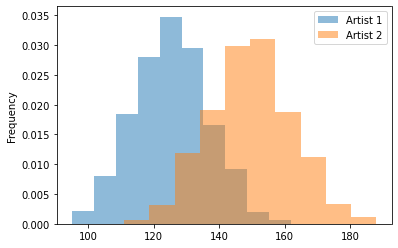

In [301]:
num_replicates = 1000

rdf = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

rdf.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: one or more whitespaces.


In [296]:
collapse_whitespace = re.compile(r'[\s]+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

artist
smash mouth    AxesSubplot(0.125,0.125;0.775x0.755)
wallows        AxesSubplot(0.125,0.125;0.775x0.755)
Name: new_num_tokens, dtype: object

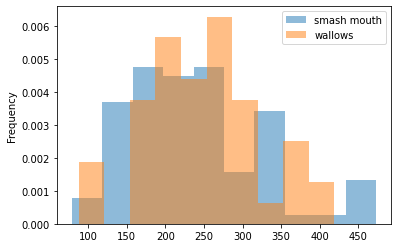

In [297]:
# Your lyric length comparison chart here. 
df['new_tokenized_lyrics'] = df['text'].map(tokenize_lyrics)
df['new_num_tokens'] = df['new_tokenized_lyrics'].map(len)
df.groupby('artist')['new_num_tokens'].plot(kind="hist",density=True,alpha=0.5,legend=True)